In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn')
from google.colab import drive
drive.mount('/content/drive')
import os
os.chdir('/content/drive/My Drive/cfrm523/Final_project')
from datetime import datetime
import tensorflow as tf

<ipython-input-1-5adfed062f48>:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


Mounted at /content/drive


In [ ]:
data = pd.read_csv('crypto_mar_april.csv')
data['date'] = pd.to_datetime(data['date'])
data = data.drop('Unnamed: 0', axis=1)

df = data.loc[data['date'] >= datetime(2024,3,1,0,0,0)]
df = df.loc[df['date'] <= datetime(2024,3,5,0,0,0)]
df = df.drop_duplicates()
df = df.reset_index(drop=True)

btc = df.loc[df['ticker']=='BTC-USD']
btc = btc.reset_index(drop=True)
btc = btc.set_index('date')

eth = df.loc[df['ticker']=='ETH-USD']
eth = eth.reset_index(drop=True)
eth = eth.set_index('date')

ltc = df.loc[df['ticker']=='LTC-USD']
ltc = ltc.reset_index(drop=True)
ltc = ltc.set_index('date')

sol = df.loc[df['ticker']=='SOL-USD']
sol = sol.reset_index(drop=True)
sol = sol.set_index('date')

In [ ]:
def calculate_rsi(prices, window=60):
    # Calculate the price differences
    delta = prices.diff()

    # Separate gains and losses
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)

    # Calculate the average gain and loss
    avg_gain = gain.rolling(window=window, min_periods=60).mean()
    avg_loss = loss.rolling(window=window, min_periods=60).mean()

    # Calculate the relative strength (RS)
    rs = avg_gain / avg_loss

    # Calculate the RSI
    rsi = 100 - (100 / (1 + rs))

    return rsi

#add in RSI
btc['RSI'] = calculate_rsi(btc['close'])
btc['returns'] = btc['close'].pct_change()
btc = btc.dropna()

eth['RSI'] = calculate_rsi(eth['close'])
eth['returns'] = eth['close'].pct_change()
eth = eth.dropna()

ltc['RSI'] = calculate_rsi(ltc['close'])
ltc['returns'] = ltc['close'].pct_change()
ltc = ltc.dropna()

sol['RSI'] = calculate_rsi(sol['close'])
sol['returns'] = sol['close'].pct_change()
sol = sol.dropna()

In [ ]:
#function to split X
def ts_split(ts, feature_steps, target_steps):
    n_obs = len(ts) - feature_steps - target_steps + 1
    X = np.array([ts[idx:idx + feature_steps] for idx in range(n_obs)])
    return X
#function to split y
def ts_split_y(ts, feature_steps, target_steps):
    n_obs = len(ts) - feature_steps - target_steps + 1
    y = np.array([ts[idx + feature_steps:idx + feature_steps + target_steps]
                  for idx in range(n_obs)])
    return y
#split the data for all 3 assets
value_features = 60############
value_target = 60###############
################################
btc_ret = ts_split(np.array(btc['returns']), feature_steps = value_features, target_steps = value_target)
btc_rsi = ts_split(np.array(btc['RSI']), feature_steps = value_features, target_steps = value_target)
btc_close = ts_split(np.array(btc['close']), feature_steps = value_features, target_steps = value_target)

eth_ret = ts_split(np.array(eth['returns']), feature_steps = value_features, target_steps = value_target)
eth_rsi = ts_split(np.array(eth['RSI']), feature_steps = value_features, target_steps = value_target)
eth_close = ts_split(np.array(eth['close']), feature_steps = value_features, target_steps = value_target)

ltc_ret = ts_split(np.array(ltc['returns']), feature_steps = value_features, target_steps = value_target)
ltc_rsi = ts_split(np.array(ltc['RSI']), feature_steps = value_features, target_steps = value_target)
ltc_close = ts_split(np.array(ltc['close']), feature_steps = value_features, target_steps = value_target)

sol_ret = ts_split(np.array(sol['returns']), feature_steps = value_features, target_steps = value_target)
sol_rsi = ts_split(np.array(sol['RSI']), feature_steps = value_features, target_steps = value_target)
sol_close = ts_split(np.array(sol['close']), feature_steps = value_features, target_steps = value_target)

y_btc = ts_split_y(np.array(btc['close']), feature_steps = value_features, target_steps = value_target)
y_eth = ts_split_y(np.array(eth['close']), feature_steps = value_features, target_steps = value_target)
y_ltc = ts_split_y(np.array(ltc['close']), feature_steps = value_features, target_steps = value_target)
y_sol = ts_split_y(np.array(sol['close']), feature_steps = value_features, target_steps = value_target)

In [ ]:
#try with all
combined_array = np.stack((btc_close, btc_rsi, btc_ret, eth_close, eth_rsi, eth_ret, ltc_close, ltc_rsi, ltc_ret, sol_close, sol_rsi, sol_ret), axis=1)
X = combined_array
X.shape

(41583, 12, 60)

In [ ]:
# Determine the size of the validation set
train_idx = round(len(X)*0.8)
X_train_full= X[:train_idx] ## all same for each model

#test data for X and y targets
X_test= X[train_idx:]
y_test_btc = y_btc[train_idx:]
y_test_eth = y_eth[train_idx:]
y_test_ltc = y_ltc[train_idx:]
y_test_sol = y_sol[train_idx:]

val_idx = round(train_idx * 0.1)  # 10% of the training set
train_idx_final = train_idx - val_idx

# Split the training data into training and validation sets
X_train = X_train_full[:train_idx_final]
X_val = X_train_full[train_idx_final:train_idx]

#train and validation for targets
y_train_btc = y_btc[:train_idx_final]
y_val_btc = y_btc[train_idx_final:train_idx]
y_train_eth = y_eth[:train_idx_final]
y_val_eth = y_eth[train_idx_final:train_idx]
y_train_ltc = y_ltc[:train_idx_final]
y_val_ltc = y_ltc[train_idx_final:train_idx]
y_train_sol = y_sol[:train_idx_final]
y_val_sol = y_sol[train_idx_final:train_idx]

#reshape and convert all into pandas series
X_train_reshaped = X_train.reshape(X_train.shape[0], -1)
X_train_reshaped = pd.DataFrame(X_train_reshaped)
X_val_reshaped = X_val.reshape(X_val.shape[0], -1)
X_val_reshaped = pd.DataFrame(X_val_reshaped)

y_train_btc = pd.DataFrame(y_train_btc)
y_train_eth = pd.DataFrame(y_train_eth)
y_train_ltc = pd.DataFrame(y_train_ltc)
y_train_sol = pd.DataFrame(y_train_sol)

y_val_btc = pd.DataFrame(y_val_btc)
y_val_eth = pd.DataFrame(y_val_eth)
y_val_ltc = pd.DataFrame(y_val_ltc)
y_val_sol = pd.DataFrame(y_val_sol)

#reshape  test
X_test_reshaped = X_test.reshape(X_test.shape[0], -1)
X_test_reshaped = pd.DataFrame(X_test_reshaped)

y_test_btc_reshaped = y_test_btc.reshape(y_test_btc.shape[0], -1)
y_test_eth_reshaped = y_test_eth.reshape(y_test_eth.shape[0], -1)
y_test_ltc_reshaped = y_test_ltc.reshape(y_test_ltc.shape[0], -1)
y_test_sol_reshaped = y_test_sol.reshape(y_test_sol.shape[0], -1)

y_test_btc_reshaped = pd.DataFrame(y_test_btc_reshaped)
y_test_eth_reshaped = pd.DataFrame(y_test_eth_reshaped)
y_test_ltc_reshaped = pd.DataFrame(y_test_ltc_reshaped)
y_test_sol_reshaped = pd.DataFrame(y_test_sol_reshaped)

In [ ]:
X_train_reshaped

,0,1,2,3,4,5,6,7,8,9,...,710,711,712,713,714,715,716,717,718,719
0,61518.59,61463.27,61404.06,61411.30,61404.76,61411.11,61418.23,61347.44,61375.14,61315.60,...,0.010986,-0.003938,-0.003807,-0.003087,0.000958,0.002283,-0.004262,0.002288,-0.001104,-0.002433
1,61463.27,61404.06,61411.30,61404.76,61411.11,61418.23,61347.44,61375.14,61315.60,61327.66,...,-0.003938,-0.003807,-0.003087,0.000958,0.002283,-0.004262,0.002288,-0.001104,-0.002433,0.003473
2,61404.06,61411.30,61404.76,61411.11,61418.23,61347.44,61375.14,61315.60,61327.66,61377.22,...,-0.003807,-0.003087,0.000958,0.002283,-0.004262,0.002288,-0.001104,-0.002433,0.003473,-0.001767
3,61411.30,61404.76,61411.11,61418.23,61347.44,61375.14,61315.60,61327.66,61377.22,61449.21,...,-0.003087,0.000958,0.002283,-0.004262,0.002288,-0.001104,-0.002433,0.003473,-0.001767,0.002656
4,61404.76,61411.11,61418.23,61347.44,61375.14,61315.60,61327.66,61377.22,61449.21,61472.63,...,0.000958,0.002283,-0.004262,0.002288,-0.001104,-0.002433,0.003473,-0.001767,0.002656,0.003605
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29934,65340.39,65421.93,65370.47,65455.92,65448.39,65463.71,65220.34,65087.91,65017.87,64888.65,...,-0.000223,0.001841,-0.000780,-0.000557,-0.001283,-0.003294,-0.000840,0.001514,0.002463,-0.002122
29935,65421.93,65370.47,65455.92,65448.39,65463.71,65220.34,65087.91,65017.87,64888.65,64747.98,...,0.001841,-0.000780,-0.000557,-0.001283,-0.003294,-0.000840,0.001514,0.002463,-0.002122,0.003022
29936,65370.47,65455.92,65448.39,65463.71,65220.34,65087.91,65017.87,64888.65,64747.98,64687.00,...,-0.000780,-0.000557,-0.001283,-0.003294,-0.000840,0.001514,0.002463,-0.002122,0.003022,-0.001507
29937,65455.92,65448.39,65463.71,65220.34,65087.91,65017.87,64888.65,64747.98,64687.00,64776.89,...,-0.000557,-0.001283,-0.003294,-0.000840,0.001514,0.002463,-0.002122,0.003022,-0.001507,0.002962


In [ ]:
def reset_session(seed=42):
    tf.random.set_seed(seed)
    np.random.seed(seed)
    tf.keras.backend.clear_session()

In [ ]:
y_train_btc[59]

0        61000.09
1        60996.98
2        60993.17
3        60998.09
4        61002.14
           ...   
29934    65580.05
29935    65531.61
29936    65547.46
29937    65603.67
29938    65601.55
Name: 59, Length: 29939, dtype: float64

In [ ]:
#try BTC model
reset_session()
tf.random.set_seed(42)
norm_layer = tf.keras.layers.Normalization(input_shape=X_train_reshaped.shape[1:])
model_BTC = tf.keras.Sequential([
    norm_layer,
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(1)
])

optimizer = tf.keras.optimizers.Nadam(learning_rate=1e-3)
model_BTC.compile(loss="mse", optimizer=optimizer)
#norm_layer.adapt(X_train_reshaped)
history_BTC = model_BTC.fit(X_train_reshaped, y_train_btc[59], epochs=30, validation_data=(X_val_reshaped, y_val_btc[59]))
#mse_test, rmse_test = model_BTC.evaluate(X_test_reshaped, y_test_btc)

Epoch 1/30
936/936 [==============================] - 8s 6ms/step - loss: 9889284.0000 - val_loss: 401223.8750
Epoch 2/30
936/936 [==============================] - 7s 7ms/step - loss: 1803623.2500 - val_loss: 1626729.2500
Epoch 3/30
936/936 [==============================] - 5s 5ms/step - loss: 1549269.8750 - val_loss: 517209.9062
Epoch 4/30
936/936 [==============================] - 5s 6ms/step - loss: 1454838.5000 - val_loss: 261971.8594
Epoch 5/30
936/936 [==============================] - 6s 7ms/step - loss: 1140774.1250 - val_loss: 275797.2812
Epoch 6/30
936/936 [==============================] - 5s 5ms/step - loss: 1127157.3750 - val_loss: 685466.7500
Epoch 7/30
936/936 [==============================] - 6s 7ms/step - loss: 1043885.2500 - val_loss: 1412692.3750
Epoch 8/30
936/936 [==============================] - 5s 5ms/step - loss: 972146.3125 - val_loss: 1079058.7500
Epoch 9/30
936/936 [==============================] - 5s 5ms/step - loss: 934657.5625 - val_loss: 199902.5938


260/260 [==============================] - 1s 2ms/step


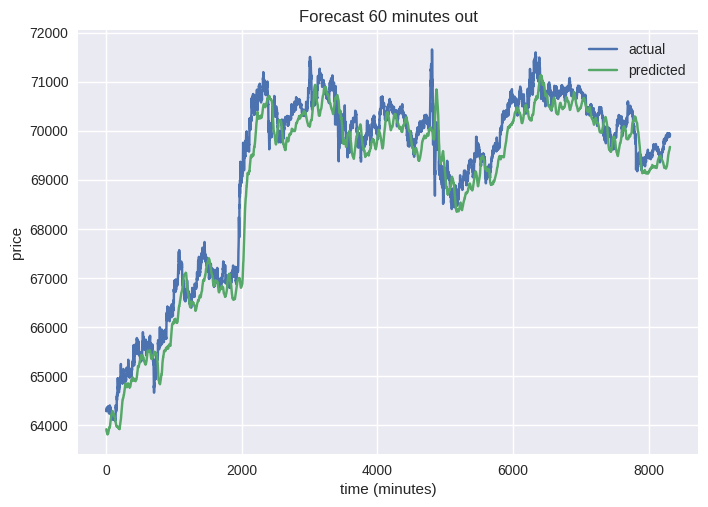

MSE:233147.4272694692


In [ ]:
from sklearn.metrics import mean_squared_error

X_new = X_test_reshaped[:]
y_pred = model_BTC.predict(X_new)

plt.plot(y_test_btc[:,value_target-1], label="actual")
plt.plot(y_pred, label='predicted')
plt.xlabel('time (minutes)')
plt.ylabel('price')
plt.legend()
plt.title(f'Forecast {value_target} minutes out')
plt.show()

mse = mean_squared_error(y_test_btc[:,value_target-1], y_pred)
print(f'MSE:{mse}')

In [ ]:
d = {'predicted':y_pred.ravel(), 'actual':y_test_btc[:,value_target-1]}
new_df = pd.DataFrame(data=d)
new_df['difference'] = new_df['predicted'] - new_df['actual']
print(new_df['difference'].mean())
print(new_df)

-274.4956222383371
         predicted    actual  difference
0     63914.480469  64291.37 -376.889531
1     63900.468750  64286.68 -386.211250
2     63891.812500  64282.64 -390.827500
3     63882.304688  64315.65 -433.345313
4     63872.125000  64311.44 -439.315000
...            ...       ...         ...
8312  69641.882812  69919.71 -277.827188
8313  69653.375000  69928.74 -275.365000
8314  69662.898438  69896.82 -233.921563
8315  69671.679688  69903.75 -232.070312
8316  69671.187500  69933.54 -262.352500

[8317 rows x 3 columns]


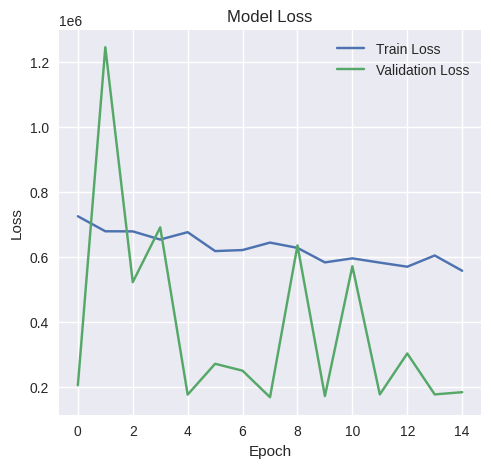

In [ ]:
# Plotting the loss
plt.figure(figsize=(12, 5))

# Plot training & validation loss values
plt.subplot(1, 2, 1)
plt.plot(history_BTC.history['loss'][15:], label='Train Loss')
plt.plot(history_BTC.history['val_loss'][15:], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')

In [ ]:
y_pred[10]

array([63783.18], dtype=float32)

In [ ]:
y_test_btc[10][59]

64258.77

In [ ]:
#try BTC model
reset_session()
tf.random.set_seed(42)
norm_layer = tf.keras.layers.Normalization(input_shape=X_train_reshaped.shape[1:])
model_ETH = tf.keras.Sequential([
    norm_layer,
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(1)
])

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
model_ETH.compile(loss="mse", optimizer=optimizer)
#norm_layer.adapt(X_train_reshaped)
history_ETH = model_ETH.fit(X_train_reshaped, y_train_eth, epochs=30, validation_data=(X_val_reshaped, y_val_eth))
#mse_test, rmse_test = model_BTC.evaluate(X_test_reshaped, y_test_btc)

Epoch 1/30
933/933 [==============================] - 16s 15ms/step - loss: 243591.5469 - val_loss: 22160.3066
Epoch 2/30
933/933 [==============================] - 15s 16ms/step - loss: 14179.2695 - val_loss: 7017.3721
Epoch 3/30
933/933 [==============================] - 12s 13ms/step - loss: 5629.3008 - val_loss: 1646.0620
Epoch 4/30
933/933 [==============================] - 8s 9ms/step - loss: 4270.3687 - val_loss: 711.7404
Epoch 5/30
933/933 [==============================] - 10s 11ms/step - loss: 4258.3604 - val_loss: 12424.7002
Epoch 6/30
933/933 [==============================] - 14s 15ms/step - loss: 4377.5508 - val_loss: 523.8759
Epoch 7/30
933/933 [==============================] - 11s 11ms/step - loss: 45458.0117 - val_loss: 405150.0000
Epoch 8/30
933/933 [==============================] - 8s 9ms/step - loss: 9061.2725 - val_loss: 752.6686
Epoch 9/30
933/933 [==============================] - 7s 8ms/step - loss: 2500.0242 - val_loss: 642.5745
Epoch 10/30
933/933 [=========

260/260 [==============================] - 1s 3ms/step


Text(0.5, 1.0, 'ETH Forecast 60 minutes out')

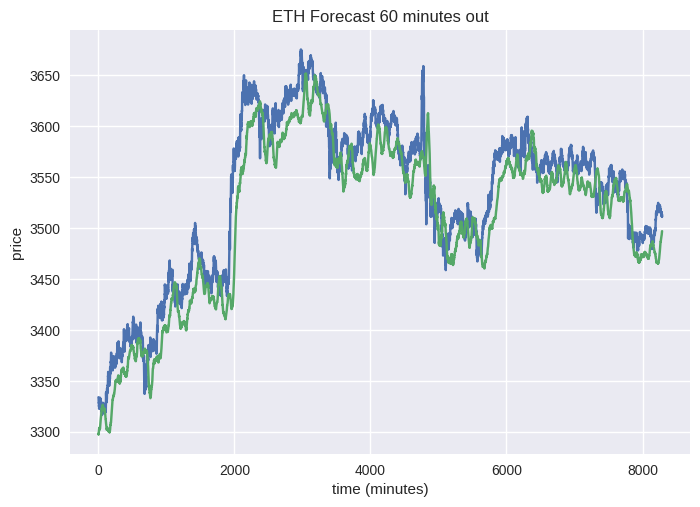

In [ ]:
X_new = X_test_reshaped[:]
y_pred_eth = model_ETH.predict(X_test_reshaped)

test_vals_adj = []
for i in range(len(y_test_eth)):
  test_vals_adj.append(y_test_eth[i][value_target-1])

plt.plot(test_vals_adj, label="predicted")
plt.plot(y_pred_eth, label='actual')
plt.xlabel('time (minutes)')
plt.ylabel('price')
plt.title(f'ETH Forecast {value_target} minutes out')

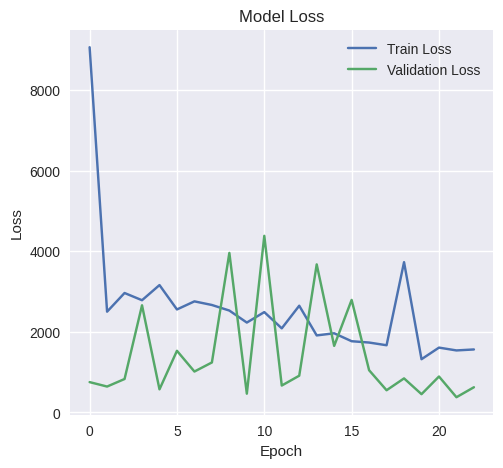

In [ ]:
# Plotting the loss
plt.figure(figsize=(12, 5))

# Plot training & validation loss values
plt.subplot(1, 2, 1)
plt.plot(history_ETH.history['loss'][7:], label='Train Loss')
plt.plot(history_ETH.history['val_loss'][7:], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')

In [ ]:
y_pred[0]

array([3297.7266], dtype=float32)

In [ ]:
y_test_btc[0]

array([64153.91, 64135.85, 64128.55, 64194.88, 64220.38, 64243.24,
       64235.47, 64203.69, 64189.64, 64250.88, 64239.07, 64241.57,
       64182.34, 64181.82, 64161.77, 64139.91, 64188.16, 64199.72,
       64216.06, 64127.88, 64155.17, 64170.59, 64208.69, 64224.09,
       64231.3 , 64260.53, 64248.7 , 64294.94, 64323.72, 64307.28,
       64283.08, 64291.37, 64286.68, 64282.64, 64315.65, 64311.44,
       64298.45, 64288.42, 64334.16, 64354.27, 64324.63, 64337.89,
       64311.06, 64325.19, 64321.08, 64305.23, 64317.  , 64331.71,
       64329.85, 64349.28, 64303.88, 64287.3 , 64339.27, 64359.11,
       64356.54, 64351.16, 64353.97, 64380.76, 64365.78, 64368.53])

In [ ]:
print(y_test_btc.shape, y_pred.shape)

(8289, 60) (8289, 1)


In [ ]:
y_test_btc[1]

array([64135.85, 64128.55, 64194.88, 64220.38, 64243.24, 64235.47,
       64203.69, 64189.64, 64250.88, 64239.07, 64241.57, 64182.34,
       64181.82, 64161.77, 64139.91, 64188.16, 64199.72, 64216.06,
       64127.88, 64155.17, 64170.59, 64208.69, 64224.09, 64231.3 ,
       64260.53, 64248.7 , 64294.94, 64323.72, 64307.28, 64283.08,
       64291.37, 64286.68, 64282.64, 64315.65, 64311.44, 64298.45,
       64288.42, 64334.16, 64354.27, 64324.63, 64337.89, 64311.06,
       64325.19, 64321.08, 64305.23, 64317.  , 64331.71, 64329.85,
       64349.28, 64303.88, 64287.3 , 64339.27, 64359.11, 64356.54,
       64351.16, 64353.97, 64380.76, 64365.78, 64368.53, 64365.66])

In [ ]:
X_test.shape

(8289, 12, 200)

In [ ]:
pred_try = model_BTC.predict(X_test_reshaped.iloc[:500])

16/16 [==============================] - 0s 6ms/step


In [ ]:
pred_try.shape

(500, 1)

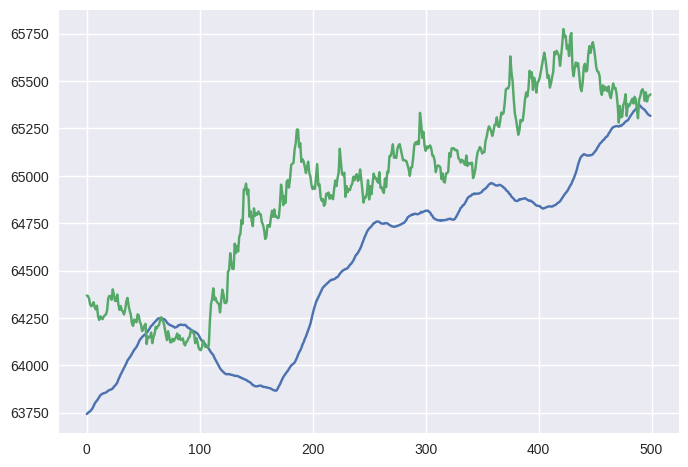

In [ ]:
plt.plot(pred_try)
plt.plot(y_test_btc[:500,59])

In [ ]:
umm = np.diff(y_test_btc[:500,59]) > 0
hmm = np.diff(pred_try[:,0]) > 0

In [ ]:
np.mean(umm==hmm)

0.48096192384769537

In [ ]:
hmm

False

In [ ]:
X_test_reshaped.iloc[0][198:202]

198    64110.460000
199    64146.580000
200       52.564982
201       51.332704
Name: 0, dtype: float64

In [ ]:
X_test_reshaped.iloc[1][198:202]

198    64146.580000
199    64153.910000
200       51.332704
201       51.737602
Name: 1, dtype: float64

In [ ]:
y_test_btc[:2]

array([[64153.91, 64135.85, 64128.55, 64194.88, 64220.38, 64243.24,
        64235.47, 64203.69, 64189.64, 64250.88, 64239.07, 64241.57,
        64182.34, 64181.82, 64161.77, 64139.91, 64188.16, 64199.72,
        64216.06, 64127.88, 64155.17, 64170.59, 64208.69, 64224.09,
        64231.3 , 64260.53, 64248.7 , 64294.94, 64323.72, 64307.28,
        64283.08, 64291.37, 64286.68, 64282.64, 64315.65, 64311.44,
        64298.45, 64288.42, 64334.16, 64354.27, 64324.63, 64337.89,
        64311.06, 64325.19, 64321.08, 64305.23, 64317.  , 64331.71,
        64329.85, 64349.28, 64303.88, 64287.3 , 64339.27, 64359.11,
        64356.54, 64351.16, 64353.97, 64380.76, 64365.78, 64368.53],
       [64135.85, 64128.55, 64194.88, 64220.38, 64243.24, 64235.47,
        64203.69, 64189.64, 64250.88, 64239.07, 64241.57, 64182.34,
        64181.82, 64161.77, 64139.91, 64188.16, 64199.72, 64216.06,
        64127.88, 64155.17, 64170.59, 64208.69, 64224.09, 64231.3 ,
        64260.53, 64248.7 , 64294.94, 64323.72,